In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from nansat import Nansat, Domain, NSR

from sea_ice_drift import get_n
from sea_ice_drift.ftlib import feature_tracking
from sea_ice_drift.pmlib import pattern_matching

import csv

%matplotlib inline

In [22]:
# use original Sentinel-1 SAR files (download from colhub.met.no)
f1 = '/home/jovyan/work/icedrift/Special_curriculum/SVL/S1A_EW_GRDM_1SDH_20221119T072104_20221119T072208_045960_057FE5_E8B1.SAFE'
f2 = '/home/jovyan/work/icedrift/Special_curriculum/SVL/S1A_EW_GRDM_1SDH_20221120T080155_20221120T080259_045975_05805E_51E1.SAFE'
# create Nansat objects with one band only. 
n1 = get_n(f1, bandName='sigma0_HH', remove_spatial_mean=True) 
n2 = get_n(f2, bandName='sigma0_HH', remove_spatial_mean=True) 
#HV
#n1 = get_n(f1)
#n2 = get_n(f2)

# 1) Run drift algorithm with swapped images (for example 2.05 for n1 and 1.05 for n2) so the final deformation would be distributed on a regular grid for 2nd SAR image

VMIN:  -5.334486770629882
VMAX:  6.069247255325315
VMIN:  -3.387907314300537
VMAX:  4.770930914878845


In [23]:
# Run Feature Tracking
# get start/end coordinates in the image coordinate system (colums/rows)  
c1, r1, c2, r2 = feature_tracking(n1, n2, nFeatures=20000, ratio_test=0.7)

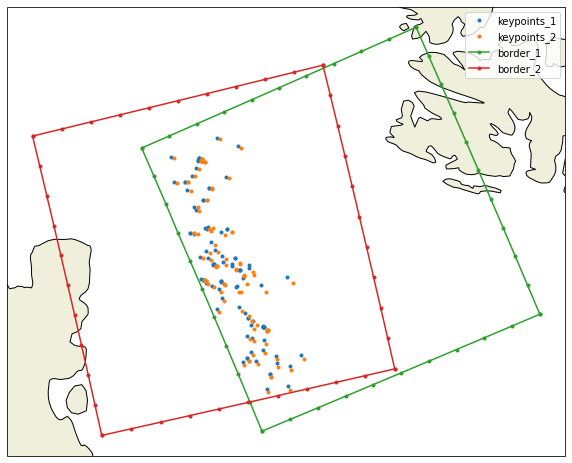

In [24]:
# Plot identified and matched keypoints in geographic coordinates

# convert row/column coordinates of matched features to lon/lat
lon1ft, lat1ft = n1.transform_points(c1, r1)
lon2ft, lat2ft = n2.transform_points(c2, r2)

# get lon/lat coordinates of the border of images
lon1b, lat1b = n1.get_border()
lon2b, lat2b = n2.get_border()


# get hi-res landmask
land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor=cfeature.COLORS['land'])

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=-45, true_scale_latitude=70))
ax.add_feature(land_50m, zorder=0, edgecolor='black')
ax.plot(lon1ft, lat1ft, '.', label='keypoints_1', transform=ccrs.PlateCarree())
ax.plot(lon2ft, lat2ft, '.', label='keypoints_2', transform=ccrs.PlateCarree())
ax.plot(lon1b, lat1b, '.-', label='border_1', transform=ccrs.PlateCarree())
ax.plot(lon2b, lat2b, '.-', label='border_2', transform=ccrs.PlateCarree())
ax.legend()
plt.show()

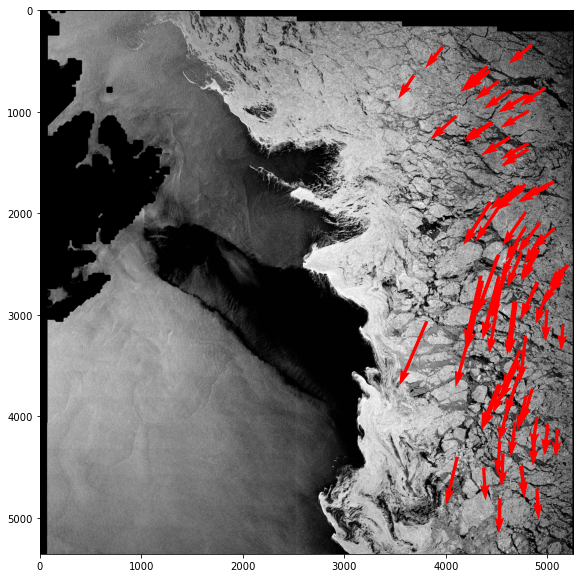

In [25]:
# Plot ice drift on top of image_1

# end points in image_1 coordinate system
n1c2, n1r2 = n1.transform_points(lon2ft, lat2ft, DstToSrc=1)

# ice drift components in image_1 coordinate system
dr = n1r2 - r1
dc = n1c2 - c1

# border of image_2 in image_1 coordinate system
n1lon2b, n1lat2b = n1.transform_points(lon2b, lat2b, DstToSrc=1)

# plot of ice drift. Arrows are 5 times longer than actual drift
plt.figure(figsize=(10,10))
plt.imshow(n1[1], cmap='gray')
plt.quiver(c1, r1, dc, dr, color='r', angles='xy', scale_units='xy', scale=0.2)
plt.plot(n1lon2b, n1lat2b, 'k.-')

plt.show()
#filename = '/home/jovyan/work/Icedrift/Nansen_algorithm/Data_and_output/Nansen_output/2500m/FT_example_HH#_1image.png'
#plt.savefig(filename, dpi=300, bbox_inches='tight')

(221, 218)


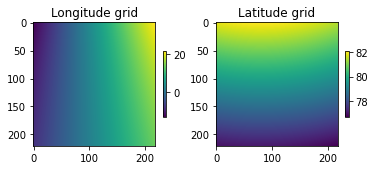

In [65]:
# Create lon/lat grids in Polar stereographic coordinate system 
# Extent of the grid roughly corresponds to the extent of the image_1

# projection (https://epsg.io/3413) or 3996
srs = NSR(3996)

# projected coordinates of the first image corners
rows, cols = n1.shape()
n1x, n1y = n1.transform_points([0,cols,cols,0], [0,0,rows,rows], dst_srs=srs)

# domain of interest with resolution 5000 (or 2500) m
dom_pm = Domain(srs.wkt, f'-te {n1x.min()} {n1y.min()} {n1x.max()} {n1y.max()} -tr 2500 2500')
print(dom_pm.shape())

# lon/lat grids in polar stereographic projection covering image_1
lon1pm, lat1pm = dom_pm.get_geolocation_grids()
plt.subplot(1,2,1);plt.imshow(lon1pm);plt.colorbar(shrink=0.3);plt.title('Longitude grid')
plt.subplot(1,2,2);plt.imshow(lat1pm);plt.colorbar(shrink=0.3);plt.title('Latitude grid')
plt.show()

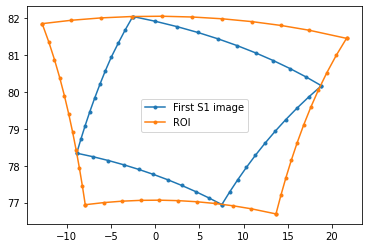

In [66]:
# plot coverage of the first S1 image and ROI
plt.plot(*n1.get_border(), '.-', label='First S1 image')
plt.plot(*dom_pm.get_border(), '.-', label='ROI')
plt.legend()
plt.show()

In [67]:
## Run Pattern Matching for each element in lon1pm/lat1pm matrix
# ice displacement upm and vpm are returned in meters in Stereographic projection
upm, vpm, apm, rpm, hpm, lon2pm, lat2pm = pattern_matching(lon1pm, lat1pm, n1, c1, r1, n2, c2, r2,
                                                          srs=srs.ExportToProj4())

/opt/conda/lib/python3.10/site-packages/sea_ice_drift-0.7.1-py3.10.egg/sea_ice_drift/pmlib.py:57: RuntimeWarning: invalid value encountered in true_divide


100% 02954.7 04918.3 00253.0 05300.0 +03.0 0.31 3.9022% 04425.5 01297.5 02311.0 01836.0 +03.0 0.83 15.0217% 02040.3 00136.6 00158.0 00403.0 -03.0 0.20 4.08
 Pattern matching - OK! ( 12 sec)


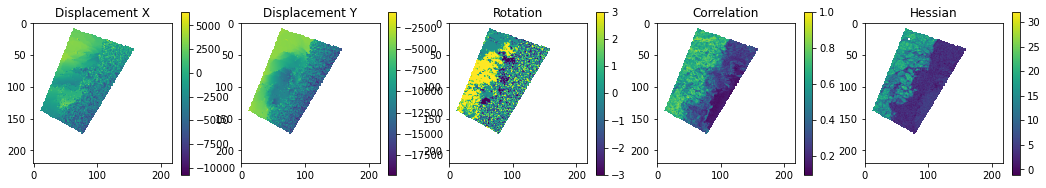

In [68]:
# plot retrieved matrices
titles = ['Displacement X', 'Displacement Y', 'Rotation', 'Correlation', 'Hessian']
fig, ax = plt.subplots(1,5, figsize=(18,3))
for i, a in enumerate([upm, vpm, apm, rpm, hpm]):
    ax[i].set_title(titles[i])
    im = ax[i].imshow(a)
    plt.colorbar(im, ax=ax[i])

plt.show()

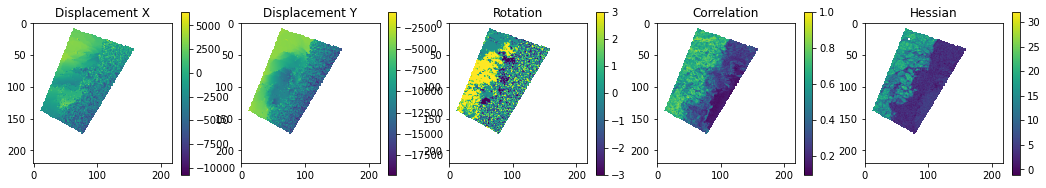

In [69]:
# plot retrieved matrices
titles = ['Displacement X', 'Displacement Y', 'Rotation', 'Correlation', 'Hessian']
fig, ax = plt.subplots(1,5, figsize=(18,3))
for i, a in enumerate([upm, vpm, apm, rpm, hpm]):
    ax[i].set_title(titles[i])
    im = ax[i].imshow(a)
    plt.colorbar(im, ax=ax[i])

plt.show()

In [70]:
# image_1 in stereographic projection

# domain of interest with resolution 500 m for SAR image reprojection (-te - extent -tr  - resolution -ts - size
dom_sar = Domain(srs.wkt, f'-te {n1x.min()} {n1y.min()} {n1x.max()} {n1y.max()} -tr 500 500')
n1.reproject(dom_sar) #n1.export
n1b1pro = n1[1]
n1.undo()

In [51]:
# image_2 in stereographic projection

# domain of interest with resolution 500 m for SAR image reprojection (-te - extent -tr  - resolution -ts - size
dom_sar = Domain(srs.wkt, f'-te {n1x.min()} {n1y.min()} {n1x.max()} {n1y.max()} -tr 500 500')
n2.reproject(dom_sar) 
n2b1pro = n2[1]
n2.undo()

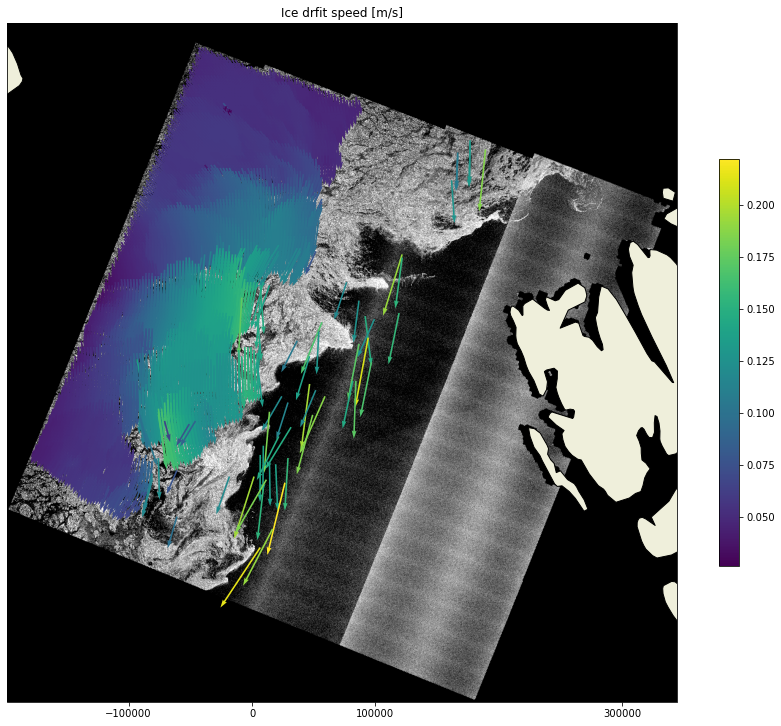

In [71]:
# compute ice drift speed [m/s]
delta_t = (n2.time_coverage_start - n1.time_coverage_start).total_seconds()
u = upm / delta_t
v = vpm / delta_t

# plot valid vectors in Polar stereographic projection
gpi = (hpm > 7) 


#To colour arrows as velocities and not correlation
speed = np.sqrt(v**2+u**2) 
# X/Y grids in polar stereographic projection covering image_1
x1pm, y1pm = dom_pm.get_geolocation_grids(dst_srs=srs)

# spacial reference for plotting (-45 and 70 for 3413)
crs = ccrs.NorthPolarStereo(central_longitude=0, true_scale_latitude=75)

plt.figure(figsize=(15,15))
ax = plt.axes(projection=crs)

ax.imshow(n1b1pro, cmap='gray', extent=[x1pm.min(), x1pm.max(), y1pm.min(), y1pm.max()], origin='upper')
quiv=ax.quiver(x1pm[gpi], y1pm[gpi], u[gpi], v[gpi],speed[gpi], scale=2)
plt.colorbar(quiv, shrink=0.5)
plt.quiverkey(quiv, 110000, -770000, 0.05, '0.05 m/s', coordinates='data')
plt.title('Ice drfit speed [m/s]')
ax.add_feature(land_50m, edgecolor='black')
ax.set_xticks([-300000, -100000, 0, 100000, 300000])
ax.set_yticks([-700000, -500000, -300000])



ax.set_xlim([x1pm.min(), x1pm.max()])
ax.set_ylim([y1pm.min(), y1pm.max()])

#for plotting inf values (they are the same for u and v)
#inf = np.where(np.isinf(u))
#plt.plot(x1pm[inf]  , y1pm[inf], 'r*')
#nan = np.where(np.isnan(u))
#plt.plot(x1pm[nan]  , y1pm[nan], 'r*')

plt.show()

In [113]:
#EXPORTING DATA TO 'DEFORMATION' NOTEBOOK, GETTING BACK RESULTS AND VISUALIZING DEFORMATION
%store upm
%store vpm
%store rpm
%store f1
%store f2

Stored 'upm' (ndarray)
Stored 'vpm' (ndarray)
Stored 'rpm' (ndarray)
Stored 'f1' (str)
Stored 'f2' (str)


In [85]:
#Prepare data for export

#Replace inf with nan. It seems that lat2, lon2 sometimes get inf and it effects u and v
#then it gives errors in alignment algortihm
infu = np.where(np.isinf(upm))
infv = np.where(np.isinf(vpm))
upm[infu] = np.nan
vpm[infv] = np.nan


#Get pixel coordinates
c1_pm, r1_pm = n1.transform_points(lon1pm.flatten(), lat1pm.flatten(), DstToSrc=1)
c2_pm, r2_pm = n1.transform_points(lon1pm.flatten(), lat1pm.flatten(), DstToSrc=1)


#Do I need to round them so it would assigned to the center of pixel?
import math
c1_round = np.array(list(map(math.ceil, c1_pm)))
r1_round = np.array(list(map(math.ceil, r1_pm)))
c2_round = np.array(list(map(math.ceil, c2_pm)))
r2_round = np.array(list(map(math.ceil, r2_pm)))
'''
#Or just round tehm to the 3rd decimal?
c1_round = np.around(c1_pm, decimals=5)
r1_round = np.around(r1_pm, decimals=5)
c2_round = np.around(c2_pm, decimals=5)
r2_round = np.around(r2_pm, decimals=5)

'''
#Round other parameters
upm_round = np.around(upm, decimals=3)
vpm_round = np.around(vpm, decimals=3)


pixel_size = 2500
# drift field displacement in pixel
u_pix = upm_round/pixel_size
v_pix = vpm_round/pixel_size



upm_pixel_round = np.around(u_pix, decimals=3)
vpm_pixel_round = np.around(v_pix, decimals=3)
apm_round = np.around(apm, decimals=3)
rpm_round = np.around(rpm, decimals=3)
hpm_round = np.around(hpm, decimals=3)

In [54]:
#EXPORTING DRIFT POINTS WITH ALL DATA IN WGS COORDINATE SYSTEM in degrees (v and u - displacement, to calculate speed use delta_t)

lon1_flat, lat1_flat, lon2_flat,lat2_flat = lon1pm.flatten(),lat1pm.flatten(), lon2pm.flatten(),lat2pm.flatten()

#delta_t = (n2.time_coverage_start - n1.time_coverage_start).total_seconds()
#u = upm / delta_t
#v = vpm / delta_t

u_flat, v_flat, a_flat, r_flat, h_flat = upm_round.flatten(), vpm_round.flatten(), apm_round.flatten(), rpm_round.flatten(), hpm_round.flatten()

In [59]:
points=zip(c1_round, r1_round, lon1_flat,lat1_flat, lon2_flat, lat2_flat, u_pix_flat, v_pix_flat, u_flat, v_flat, a_flat, r_flat, h_flat)
#points=zip(lon1_flat,lat1_flat, u_flat, v_flat)
header=['c1','r1','lon1','lat1', 'lon2','lat2', 'u_pix', 'v_pix', 'u','v', 'a','r', 'h']

with open('/home/jovyan/work/Icedrift/Nansen_algorithm/Data_and_output/Nansen_output/2500m/19-20_nov_drift_HH.csv','w') as f: 
    out = csv.writer(f, delimiter=',')
    out.writerow(header) 
    out.writerows(points)

In [170]:
# domain of interest with resolution 5000 (or 2500) m

#rows2, cols2 = n2.shape()
#n2x, n2y = n2.transform_points([0,cols2,cols2,0], [0,0,rows2,rows2], dst_srs=srs)
#dom2_pm = Domain(srs.wkt, f'-te {n2x.min()} {n2y.min()} {n2x.max()} {n2y.max()} -tr 2500 2500')
x1_pix, y1_pix = n1.transform_points(lon1pm.flatten(), lat1pm.flatten(), DstToSrc=True)
x2_pix, y2_pix = n2.transform_points(lon2pm.flatten(), lat2pm.flatten(), DstToSrc=True)

x1pm_flat, y1pm_flat = n1.transform_points(x1_pix.flatten(), y1_pix.flatten(), DstToSrc=0, dst_srs=srs)
x2pm_flat, y2pm_flat = n2.transform_points(x2_pix.flatten(), y2_pix.flatten(), DstToSrc=0, dst_srs=srs)


#x1pm_flat, y1pm_flat = n1.transform_points(c1_pm.flatten(), r1_pm.flatten(), DstToSrc=0, dst_srs=srs)
#x2pm_flat, y2pm_flat = n2.transform_points(c2_pm.flatten(), r2_pm.flatten(), DstToSrc=0, dst_srs=srs)
#x1pm_flat, y1pm_flat =x1pm.flatten(), y1pm.flatten()

inf_x2pm_flat = np.where(np.isinf(x2pm_flat))
inf_y2pm_flat = np.where(np.isinf(y2pm_flat))
x2pm_flat[inf_x2pm_flat] = np.nan
y2pm_flat[inf_y2pm_flat] = np.nan

In [171]:
#Exporting lon1 lat1 and lon2 lat 2 format csv

points=zip(x1pm_flat, y1pm_flat, x2pm_flat,y2pm_flat)
header=['x1pm', 'y1pm', 'x2pm','y2pm']

with open('/home/jovyan/work/Icedrift/Nansen_algorithm/Data_and_output/Nansen_output/2500m/lat12_lon12_input/19-20_nov_drift_HV.csv_proj_3996_nan.csv','w') as f: 
    out = csv.writer(f, delimiter=',')
    #out.writerow(header) 
    out.writerows(points)

In [58]:
#Exporting for Chalmers
u_pix_flat, v_pix_flat = u_pix.flatten(), v_pix.flatten()
u_pix_flat, v_pix_flat = np.around(u_pix_flat, decimals=5), np.around(v_pix_flat, decimals=5)

In [332]:
#Exporting for Chalmers
points=zip(c1_round, r1_round, u_pix_flat, v_pix_flat)
#header=['c1','r1', 'dy','dx']

with open('/home/jovyan/work/Icedrift/Nansen_algorithm/Data_and_output/Nansen_output/2500m/to_chalmers/19-20_nov_drift_HV_pixel.csv','w') as f:
    out = csv.writer(f, delimiter=',')
    #out.writerow(header) 
    out.writerows(points)

In [200]:
#Exporting quality parametres
points_q=zip(lon1_flat,lat1_flat, r_flat, h_flat)
header_q=['y1','x1','r', 'h']

with open('/home/jovyan/work/Icedrift/Nansen_algorithm/Data_and_output/Nansen_output//2000m/to_chalmers/17-18.06.20_corr_hessian_HH.csv','w') as f:
    out = csv.writer(f, delimiter=',',quoting=csv.QUOTE_ALL)
    out.writerow(header_q) 
    out.writerows(points_q)

In [244]:
#exporting from "Deformation.ipynb" filtered displacament in pixels for r>0.3
%store -r u_map
%store -r v_map

u_int_flat, v_int_flat = u_map.flatten(), v_map.flatten()

In [245]:
#exporting filtered data
points_int=zip(lon1_flat,lat1_flat, u_int_flat, v_int_flat)
header_int=['y1','x1', 'dy','dx']

with open('/home/jovyan/work/Icedrift/Nansen_algorithm/Data_and_output/Nansen_output//2000m/to_chalmers/27-28.03.20_drift_HH_filtered.csv','w') as f:
    out = csv.writer(f, delimiter=',',quoting=csv.QUOTE_ALL)
    out.writerow(header_int) 
    out.writerows(points_int)

In [203]:
%store -r divergence_sr
%store -r convergence_sr
%store -r shear_sr
%store -r total_sr

%store -r divergence_dr
%store -r convergence_dr
%store -r shear_dr
%store -r total_dr

%store -r e_div_dr

%store -r divergence_n2
%store -r convergence_n2
%store -r shear_n2
%store -r total_n2

%store -r e_tot

In [204]:
mskt = (total_dr>5)
# filter mask
msk_total_dr  = mskt*1

# filter data arrays    
total_dr_msk = total_dr*mskt

# set no data to nan
total_dr_msk[mskt==0.0] = np.nan

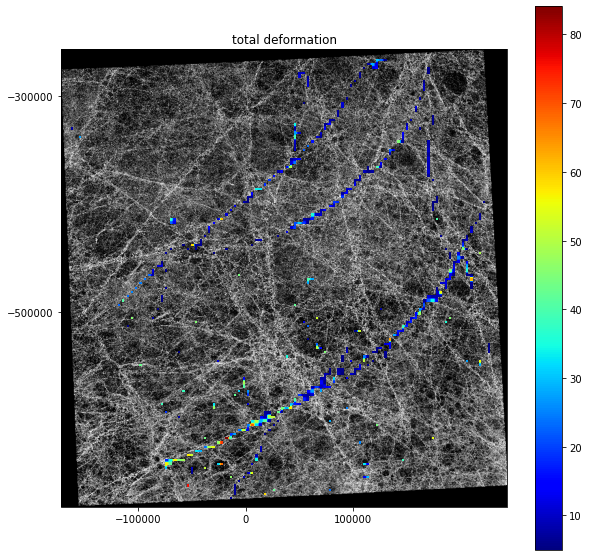

In [205]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=crs)

#(axes)  = plt.subplots(2,2, figsize=(30,30), sharex='all', sharey='all')
ax.imshow(n1b1pro, cmap='gray', extent=[x1pm.min(), x1pm.max(), y1pm.min(), y1pm.max()], origin='upper')
im=ax.imshow(total_dr_msk, extent=[x1pm.min(), x1pm.max(), y1pm.min(), y1pm.max()], origin='upper', cmap = 'jet') # for transparency  alpha = 0.3
plt.title('total deformation')
#divider = make_axes_locatable(axes[0][0])
#cax = divider.append_axes("right", size="5%", pad=0.05)
#clb1 = plt.colorbar(pm1, cax=cax)
#clb1.ax.set_xlabel(clb_txt)
#clb1.ax.tick_params(labelsize=FS-5)

ax.add_feature(land_50m, edgecolor='black')
ax.set_xticks([-300000, -100000, 0, 100000, 300000])
ax.set_yticks([-700000, -500000, -300000])
ax.set_xlim([x1pm.min(), x1pm.max()])
ax.set_ylim([y1pm.min(), y1pm.max()])
#plt.axes('off')
plt.colorbar(im)

    
    
plt.show()



In [206]:
#EXPORTING DEFORMATION TO POINTS WITH ALL DATA IN WGS COORDINATE SYSTEM in degrees
'''maybe export each type to separate file so then just batch them all into rasters'''

e_div_dr

lon1_flat, lat1_flat, lon2_flat,lat2_flat = lon1pm.flatten(),lat1pm.flatten(), lon2pm.flatten(),lat2pm.flatten()

#delta_t = (n2.time_coverage_start - n1.time_coverage_start).total_seconds()
#u = upm / delta_t
#v = vpm / delta_t

divergence, convergence, shear, total, total_div = divergence_dr.flatten(), convergence_dr.flatten(), shear_dr.flatten(), total_dr.flatten(), e_div_dr.flatten()

total_dr_msk = total_dr_msk.flatten()
total_n2 = total_n2.flatten()

In [207]:
points=zip(lon1_flat,lat1_flat, lon2_flat, lat2_flat, divergence, convergence, shear, total, total_div )
header=['lon1','lat1', 'lon2','lat2', 'divergence','convergence', 'shear','total', 'total_div']

with open('/home/jovyan/work/Icedrift/Nansen_algorithm/Data_and_output/Nansen_output/2000m/17-18_june_2020/17-18_june_deformation12_HH.csv','w') as f:
    out = csv.writer(f, delimiter=',',quoting=csv.QUOTE_ALL)
    out.writerow(header) 
    out.writerows(points)

In [161]:
points=zip(lon1_flat,lat1_flat, lon2_flat, lat2_flat, total_n2 )
header=['lon1','lat1', 'lon2','lat2', 'total_n2']

with open('/home/jovyan/work/Icedrift/Nansen_algorithm/Data_and_output/Nansen_output/2000m/27-28_march_2020/127-28_march_total_n2_12_HH.csv','w') as f:
    out = csv.writer(f, delimiter=',',quoting=csv.QUOTE_ALL)
    out.writerow(header) 
    out.writerows(points)

In [502]:
#EXPORTING DATA TO RASTER AND NETCDF (with tif it doesn't work for some reson as it distore data, it's better to export points like above)

# export u/v componets into netcdf file
n_out = Nansat.from_domain(dom_pm)
n_out2 = Nansat.from_domain(dom_pm)
n_out.add_bands([u, v], parameters=[{'name': 'u', 'units': 'm/s'}, {'name': 'v', 'units': 'm/s'}])
n_out2.add_bands([apm, rpm, hpm], parameters=[{'name':'a', 'units': '_'}, {'name':'r','units': '_'}, {'name':'h','units': '_'}])


#n_out.export('test_export_uv.nc')
# check exported file with ncdump
#!ncdump -h test_export_uv.nc
n_out.export('/home/jovyan/work/icedrift/Nansen_algorithm/Data_and_output/Nansen_output/10-11_dec_2020/10-11_dec_HH_u_v.nc')
n_out2.export('/home/jovyan/work/icedrift/Nansen_algorithm/Data_and_output/Nansen_output/10-11_dec_2020/10-11_dec_HH_a_r_h.nc')
#!ncdump -h /home/jovyan/work/icedrift/Nansen_algorithm/Data_and_output/Nansen_output/14-15_march_2020/14-15_march_HH_u_v.nc
              
#for tiff
n_out.export('/home/jovyan/work/icedrift/Nansen_algorithm/Data_and_output/Nansen_output/10-11_dec_2020/10-11_dec_HH_u_v.tif', driver='GTiff')
n_out2.export('/home/jovyan/work/icedrift/Nansen_algorithm/Data_and_output/Nansen_output/10-11_dec_2020/10-11_dec_HH_a_r_h.tif', driver='GTiff')
#!gdalinfo test_export_uv.tif

In [140]:
#COMPARING LOCATIONS BETWEEN INITIAL POINTS AND RESULTING (needed to see if algorithm worked good to figure out what was giving distortion of exported data).
img1 = n1[1]
img2 = n2[1]

x1pm, y1pm = n1.transform_points(lon1pm.flatten(), lat1pm.flatten(), DstToSrc=True)
x2pm, y2pm = n2.transform_points(lon2pm.flatten(), lat2pm.flatten(), DstToSrc=True)

In [165]:
x1exp, y1exp = x1pm[5100:5105], y1pm[5100:5105]
x2exp, y2exp =x1pm[5100:5105], y1pm[5100:5105]
print(x1exp, y1exp,x2exp, y2exp)

[4337.36293111 4307.95178097 4278.53852895 4249.12156598 4219.70026077] [419.26441129 407.82609888 396.3905144  384.95767704 373.52757979] [4337.36293111 4307.95178097 4278.53852895 4249.12156598 4219.70026077] [419.26441129 407.82609888 396.3905144  384.95767704 373.52757979]


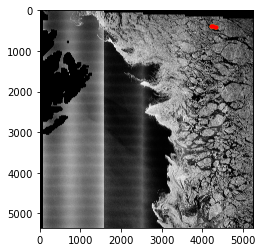

In [166]:
plt.imshow(img1, cmap='gray')
#plt.plot(x1pm[4100:4105], y1pm[4100:4105], 'y.')
#plt.plot(x1pm[3200:3205], y1pm[3200:3205], 'r.')
plt.plot(x1exp, y1exp, 'y.')
plt.plot(x2exp, y2exp, 'r.')

(3600.0, 2100.0)

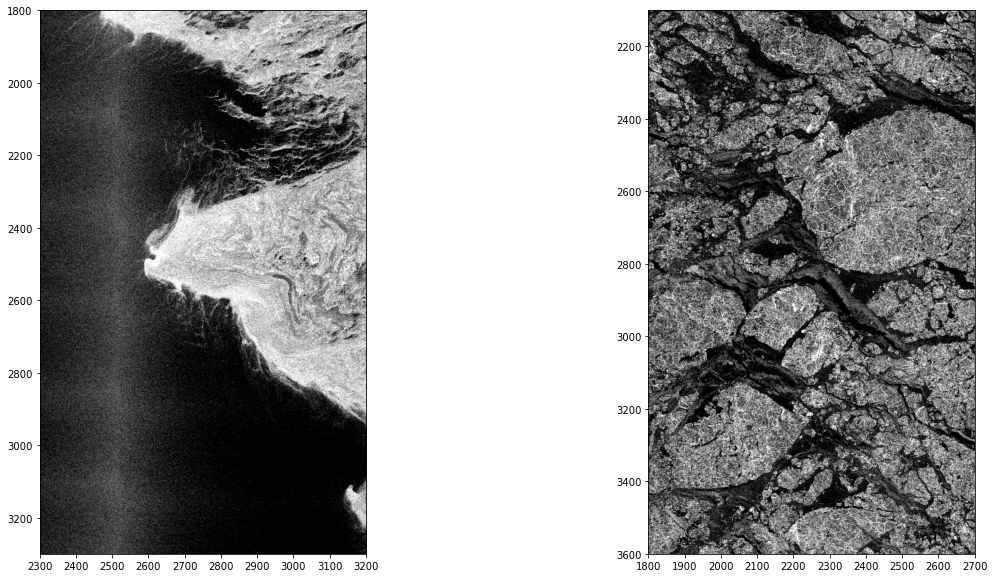

In [156]:
i0, i1 = 5100,5105
i3, i4 = 4200,4205
fig, ax = plt.subplots(1,2,figsize=(20,10))
ax[0].imshow(img1, cmap='gray')
ax[0].plot(x1pm[i0:i1], y1pm[i0:i1], 'r.', markersize=15)
ax[0].plot(x1pm[i3:i4], y1pm[i3:i4], 'y.', markersize=15)
ax[0].set_xlim([2300, 3200])
ax[0].set_ylim([3300, 1800])

ax[1].imshow(img2, cmap='gray')
ax[1].plot(x2pm[i0:i1], y2pm[i0:i1], 'r.', markersize=15)
ax[1].plot(x2pm[i3:i4], y2pm[i3:i4], 'y.', markersize=15)
ax[1].set_xlim([1800, 2700])
ax[1].set_ylim([3600, 2100])

In [ ]:
## Generate test files for simple.py
"""
filenames = [
    'S1B_EW_GRDM_1SDH_20200123T120618_20200123T120718_019944_025BA1_D4A2.SAFE',
    'S1B_EW_GRDM_1SDH_20200125T114955_20200125T115055_019973_025C81_EC1A.SAFE'
]
crop_params = [
    (1800,4400,1000,1000),
    (2400,4600,1000,1000),
]

for f,c in zip(filenames, crop_params): 
    n = Nansat(f)
    n.reproject_gcps()
    n.vrt.tps = True
    n.crop(*c)
    n.export(f[:32]+'.tif', bands=['sigma0_HV'], driver='GTiff')
#"""